In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans
import morph_geom_lib as mgl

from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex


%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background'])

# A3DOWN Simulation

Based on Table 4.3 in Wiebes thesis:




In [50]:
profile_folder = '/mnt/efs/A3DOWN 2006-06-09 (S-800, 30-15cm)'



In [114]:
a3downDF = mgl.readWiebeFiles(profile_folder, resolution = 1)
a3downDF.head()

,-15,-2,1,4,10,16,23,30,39,48,...,211,222,233,244,255,266,277,289,300,301
0.000000,-0.000500,0.003600,-0.010300,-0.011100,-0.014200,-0.013300,-0.006800,-0.007700,-0.009400,-0.013200,...,-0.006400,-0.017500,-0.029500,-0.048200,-0.003800,-0.003100,-0.000400,-0.028200,-0.028100,-0.003400
0.015019,0.003206,0.006445,-0.006348,-0.007636,-0.011491,-0.011955,-0.004730,-0.005294,-0.007300,-0.010597,...,-0.004200,-0.014045,-0.026536,-0.047906,-0.002697,-0.001282,0.001173,-0.026245,-0.026315,-0.001355
0.030038,0.006834,0.008845,-0.004634,-0.005957,-0.009834,-0.011527,-0.004734,-0.003312,-0.006049,-0.010800,...,-0.001700,-0.011452,-0.024193,-0.049200,-0.002516,0.001034,0.003134,-0.024434,-0.025655,0.000134
0.045056,0.009261,0.011189,-0.002524,-0.004200,-0.008598,-0.011635,-0.005833,-0.002922,-0.006028,-0.011211,...,-0.000200,-0.009062,-0.023456,-0.048400,-0.005978,0.002511,0.004789,-0.022542,-0.023347,0.000095
0.060075,0.011500,0.013151,-0.000200,-0.002273,-0.009014,-0.011141,-0.005318,-0.002931,-0.005385,-0.011241,...,0.000544,-0.008026,-0.022652,-0.046518,-0.010648,0.002600,0.005598,-0.021771,-0.023189,0.000849


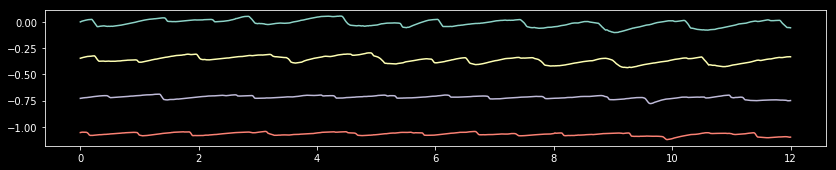

In [115]:
fig = plt.figure(figsize=(14, 2.5))
plt.plot(a3downDF.index,a3downDF[-15])
plt.plot(a3downDF.index,a3downDF[-2]- 0.35)
plt.plot(a3downDF.index,a3downDF[300] - 0.35*2.)
plt.plot(a3downDF.index,a3downDF[301]-0.35*3.)
plt.show()

In [167]:
#--------------------------------
# Set up the constants
#--------------------------------
nP=0.4
Slope = 1.26/1000 # Based on table 4.1 in Wiebe
mannings = 0.048
water_surface= 0.237     # Surface water elevation
beta = 0.01

# 32 cm Case 
Qc132 = 0.045
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B



xc = a3downDF.index.values
zc = a3downDF[1].values

sws = shallow_water_solver(kernel_language='Fortran')
sws.set_solver(max_steps=100000)
sws.set_state_domain(xc,zc)
sws.set_mannings_source_term(mannings=0.024, slope=1.26/1000.)

#sws.set_boundary_conditions()
hout = 0.19
Qin = q20cm

sws.set_Dirichlet_BC(hout,Qin)
sws.set_inital_conditions(hout, 0.0)
sws.set_controller(tfinal=300., num_output_times=3)
sws.run()
cntrl = sws.get_controller()

h = sws.get_hf()
u = sws.get_uf()
q = sws.get_qf()


2019-04-24 03:36:33,289 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-24 03:36:36,997 INFO CLAW: Solution 1 computed for time t=100.000000
2019-04-24 03:36:40,732 INFO CLAW: Solution 2 computed for time t=200.000000
2019-04-24 03:36:44,471 INFO CLAW: Solution 3 computed for time t=300.000000


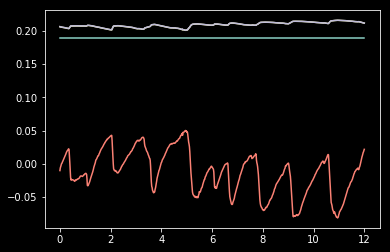

In [168]:
for i in range(cntrl.num_output_times):
    surf = cntrl.frames[i].q[0,:] + zc
    plt.plot(xc,surf)
plt.plot(xc,zc)


0.07894736842105263

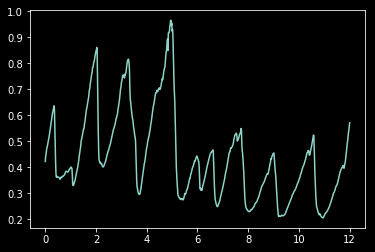

In [169]:
tau = np.zeros(nx)
for i in range(nx):
    tau[i] = sedtrans.get_bed_shear(h[i],u[i],D50)
    
plt.plot(xc,tau)
q20cm

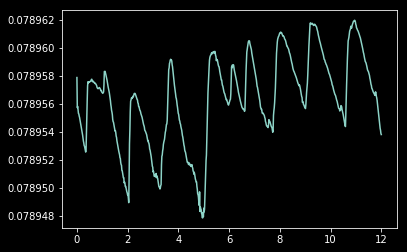

In [170]:
    
plt.plot(xc,q)

In [137]:

#--------------------------------
# Initialize the sed transport 
#--------------------------------    
# Eq 57
nx = len(xc)
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
flux = np.zeros(nx)

# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 2650



#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 30.*60 # Runtime in seconds
dt = 10 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps

dx = sws.get_state().grid.delta[0]
#--------------------------------
# Set up the model reporting parameters
#--------------------------------
xc = a3downDF.index.values
zc = a3downDF[1].values

z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []
extractionInterval = 60.*8
tsteps=[]
iterations = 0
cntr=0

#sws.set_boundary_conditions()
hout = 0.20
Qin = q20cm

sws = shallow_water_solver(kernel_language='Fortran')
sws.set_solver(max_steps=100000)
sws.set_state_domain(xc,zc)
sws.set_mannings_source_term(mannings=0.024, slope=1.26/1000.)
sws.set_Dirichlet_BC(hout,Qin)
sws.set_inital_conditions(hout, 0.0)
sws.set_controller(tfinal=300., num_output_times=3)
sws.run()
cntrl = sws.get_controller()

h = sws.get_hf()
u = sws.get_uf()
q = sws.get_qf()
#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2
        zloc = get_stencil(zn,i-2,i+4)        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)!=6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
    
    bed_max_delta = np.max(np.abs(zn - zc))
    
    # Apply the avalanche model
    zc, iterations1 = avalanche_model(dx,xc, zc, adjustment_angle=28.)
    # Now flip it to run in reverse
    zflip = np.flip(zc, axis=0)
    zflip, iterations1 = avalanche_model(dx,xc, zflip, adjustment_angle=28.)
    zc = np.flip(zflip, axis=0)
    
    #zc = z_updated.copy()
    
    # Re-run the solver and updated the sediment transport
    # Check if the avalanche model was updated OR the bed changed greater than the threshold
    #if iterations > 10 or bed_max_delta > 0.00005:
    iterations+=1
    if iterations > 2:        
        sws = shallow_water_solver(kernel_language='Fortran')
        sws.set_solver(max_steps=100000)
        sws.set_state_domain(xc,zc)
        sws.set_mannings_source_term(mannings=0.020, slope=1.26/1000.)
        sws.set_conditions_from_previous(h, q)
        sws.set_Dirichlet_BC(hout,Qin)
        sws.set_controller(tfinal=20., num_output_times=1)
        sws.run()
        cntrl = sws.get_controller()      

        h = sws.get_hf()
        u = sws.get_uf()
        q = sws.get_qf()
        surf = h + zc
        
        iterations = 0
        
    slope = np.gradient(zc,dx)
    
    if 1==1:
        # ----------------------------------
        # Apply the two-step smooting scheme Eq. 6 in Niemann et al 2011.
        # ----------------------------------
        zhat = np.zeros(nx)
        for i in range(0, nx):  # i=2
            zlocal = get_stencil(zc, i - 1, i + 2)
            zhat[i] = 0.5*zlocal[1] + 0.25*(zlocal[0]+zlocal[2])

        for i in range(0, nx):
            zhatlocal = get_stencil(zhat, i - 1, i + 2)
            zc[i] = (3./2.)*zhatlocal[1] - 0.25*(zhatlocal[0]+zhatlocal[2])


    ## Nov 13 2018 - Can modify later
    for i in range(0,nx): #i=2        
        #zlocal = get_stencil(zc,i-2,i+2)
        #qbedload[i] = sedtrans.get_unit_bed_load2(h[i],u[i],D50,rho_particule,type='bagnold')
        qbedload[i] = sedtrans.get_unit_bed_load_slope(h[i],u[i],D50,slope[i], 
                                                       rho_particule, 
                                                       angleReposeDegrees = 30.0, 
                                                       type='bagnold',
                                                        useSlopeAdjust=False)

    
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt)        
        np.save('flume_dunes', verts)
    
    cntr += 1
    if cntr == extractionInterval:
        cntr = 0
        print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))    
        
print('Done')

2019-04-24 03:14:17,293 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-24 03:14:21,050 INFO CLAW: Solution 1 computed for time t=100.000000
2019-04-24 03:14:24,817 INFO CLAW: Solution 2 computed for time t=200.000000
2019-04-24 03:14:28,571 INFO CLAW: Solution 3 computed for time t=300.000000
2019-04-24 03:14:29,872 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-24 03:14:30,619 INFO CLAW: Solution 1 computed for time t=20.000000
2019-04-24 03:14:30,957 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-24 03:14:31,687 INFO CLAW: Solution 1 computed for time t=20.000000
2019-04-24 03:14:32,017 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-24 03:14:32,752 INFO CLAW: Solution 1 computed for time t=20.000000
2019-04-24 03:14:33,099 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-24 03:14:33,830 INFO CLAW: Solution 1 computed for time t=20.000000
2019-04-24 03:14:34,274 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-24 03:1

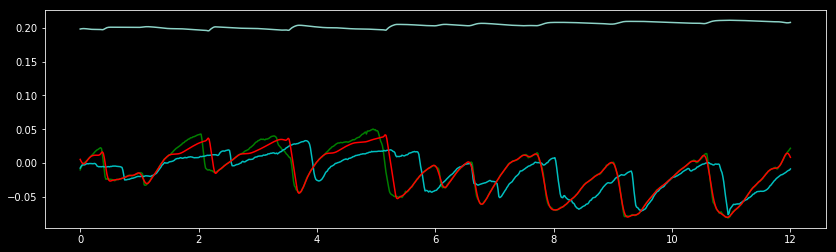

In [139]:
fig = plt.figure(figsize=(14, 4))
plt.plot(xc,surf)
plt.plot(xc,a3downDF[1],'g')
plt.plot(xc,a3downDF[30],'c')
plt.plot(xc,zc,'r')
#plt.plot(xc,profileDf['04'],'c')
#plt.plot(xc,profileDf['05'],'c')
#plt.plot(xc,a3downDF['06'],'c')

Text(0.5, 0, '$x(m)$')

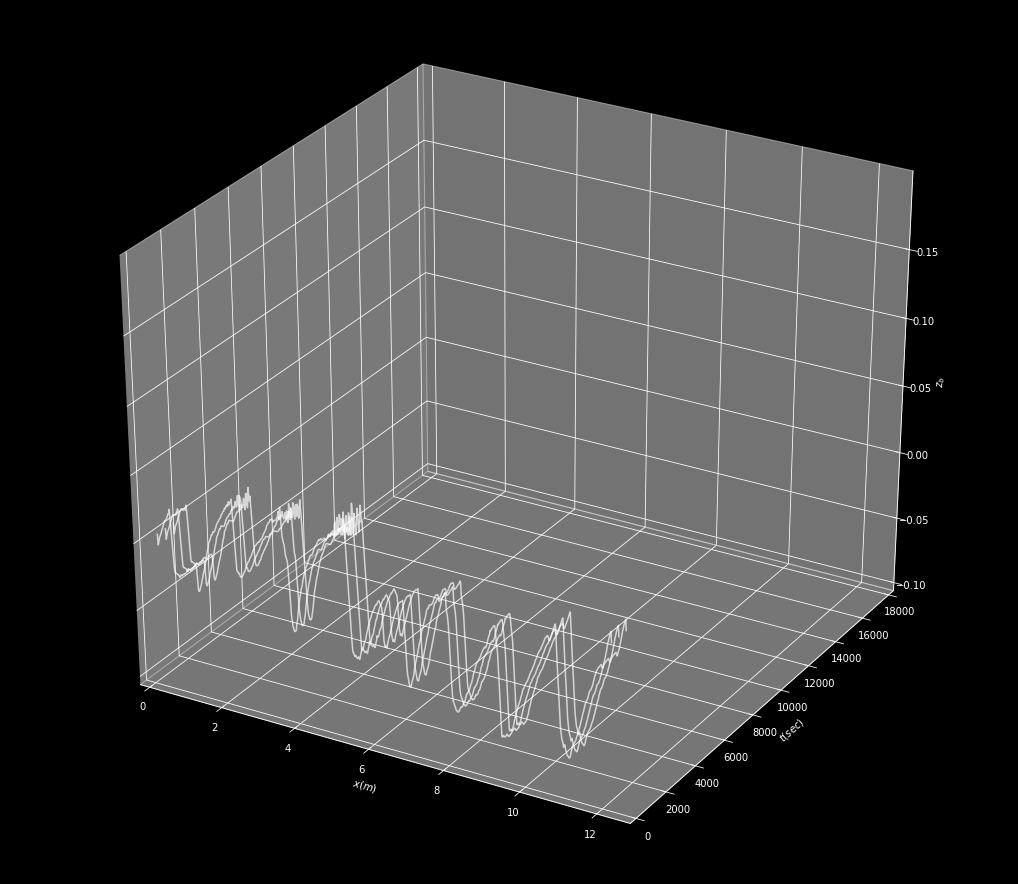

In [136]:
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D




lines = LineCollection(verts)
fig = plt.figure(figsize=(18, 16))
ax = fig.gca(projection='3d')
lines.set_alpha(0.7)
ax.add_collection3d(lines, zs=tsteps, zdir='y')
ax.set_xlim3d(0, 12.6)
ax.set_zlim3d(-0.1, .2)
ax.set_ylim3d(0, 18000)
ax.set_zlabel('$z_b$')
ax.set_ylabel('$t(sec)$')
ax.set_xlabel('$x(m)$')

0.3733489441908826


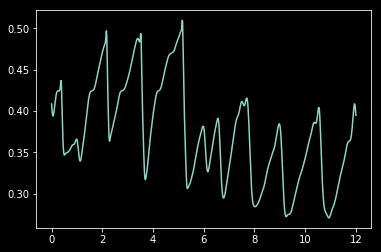

In [141]:
plt.plot(xc, u)
print(u.mean())

In [132]:
tau = np.zeros(nx)
for i in range(nx):
    tau[i] = sedtrans.get_bed_shear(h[i],u[i],D50)

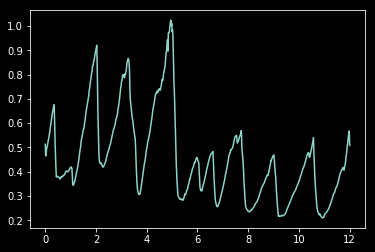

In [133]:
plt.plot(xc, tau)

In [53]:
len(profile_times)

34

AttributeError: 'list' object has no attribute 'shape'